# What do we do with errors on parameters ?

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy
from scipy.optimize import curve_fit 

import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...

# We fix the random seed to always get the same problem
np.random.seed(seed=42)

If we calculate the fit of a straigh line to data with curve_fit, we end up with some errors on parameters...

# First, go back to the 2nd order polynomial problem to create data and a fit:

Obtained parameters:
[10.04700223  1.34594678  0.02935088]
Fit RMSE is: 27.514789553715723


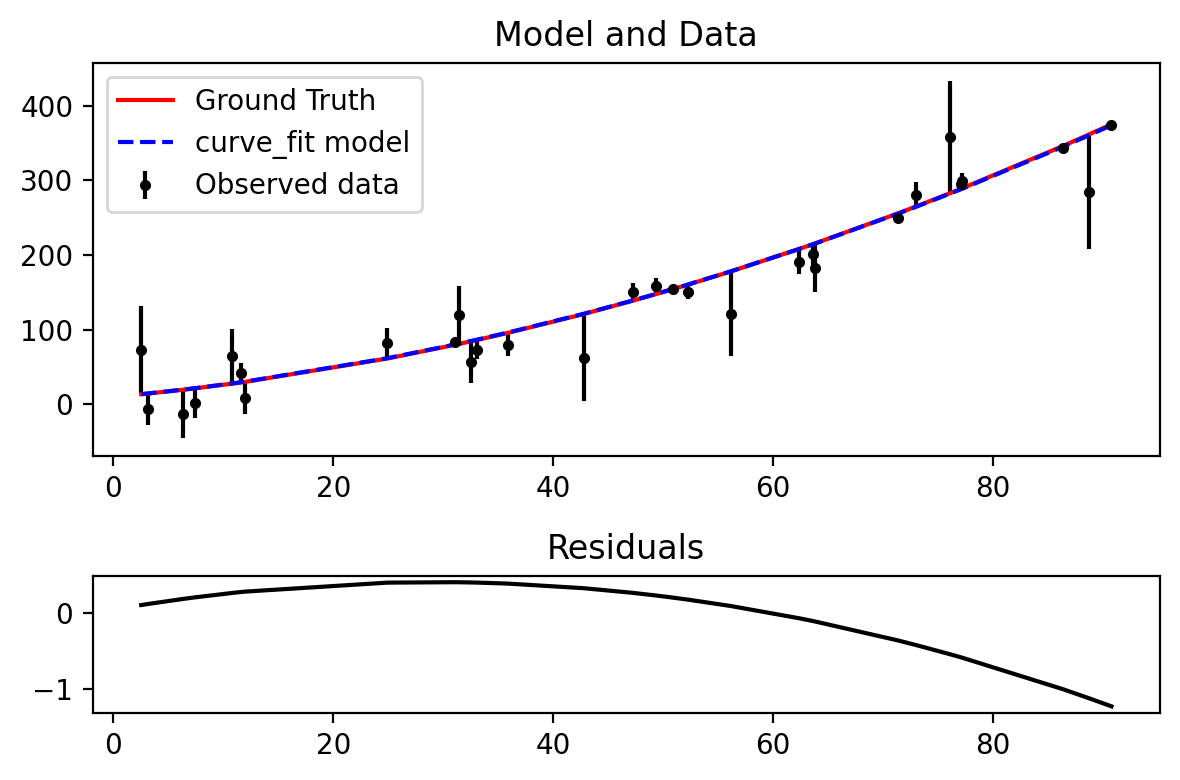

In [7]:
# THE FORWARD PROBLEM

def forward_model(x,a,b,c):
    """forward model for our problem"""
    return a + x*b + c*x*x

# DATA GENERATION

# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 30

x = np.sort(100*np.random.rand(N))
y = forward_model(x,a,b,c)

# Real world observations are noisy...
# we have random errors there, no systematic bias
ese = 40*np.random.randn(N)

y_observed = y + ese

# LEAST SQUARE FIT

# we declare a new least-squares function with errors taken into account
def least_squares_ponderated(y_observed,y_calculated, y_sigmas):
    """least square criterion"""
    return np.sum((y_observed-y_calculated)**2/(y_sigmas**2))

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(forward_model,x,y_observed,sigma=ese) 

print("Obtained parameters:")
print(popt)

# we calculate the best estimate
y_pred_curvefit = forward_model(x,*popt) # parameter unwrapping (*popt) works only in Python 3
print("Fit RMSE is: "+str(least_squares_ponderated(y_observed,y_pred_curvefit,ese)))

# FIGURE

plt.figure(dpi=200)

plt.subplot(3,1,(1,2))
plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.legend(loc="best")

plt.subplot(3,1,3)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()


# Errors on model parameters

Given the noise in our data, we have some uncertainty on the calculated value of model parameters.

A practical way of getting those uncertainties, assuming they follow a normal distribution, is to get them from the diagonal of the parameter covariance matrix.


In [6]:
# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

# we print things with a bit of string formating (see Python docs)
print("Value of a is {:.0f} +/- {:.0f}".format(popt[0],perr[0]))
print("Value of b is {:.1f} +/- {:.1f}".format(popt[1],perr[1]))
print("Value of c is {:.3f} +/- {:.3f}".format(popt[2],perr[2]))

Value of a is 10 +/- 6
Value of b is 1.3 +/- 0.4
Value of c is 0.031 +/- 0.005


## Questions : 

    - at which digit you stop when reporting parameters and errors ? Modify the code accordingly
    - the diagonal of pcov seems to contain the parameter variance... what are the other values ?


# How do we propagate errors ?

Error propagation is a true problem in itself. It is very important as it really determines the way you think about a problem.

There are several easy formula for error propagation, use Google, you will find them.

Here I will only probide two general formulas. 

The first one is for **independent parameters/variables**, meaning that they are NOT covariant in any way. When you are in this situation, we can propagate errors using the variance formula.

Given a forward function $f$ with parameters $m_i$ that return y, we have

$ \sigma_y = \sqrt(\sum(\frac{\delta f}{\delta m_i})^2\sigma_{m_i}^2)$ eq. 1

For simple problems, this function is easy to calculate, but for more complex ones, it becomes a lot of work. Fortunately, modern computing solved the problem for us! For instance, in Python, you can use the package *uncertainties* to do the job.

Read the DOCS !  https://pythonhosted.org/uncertainties/

We try it below :

In [8]:
# loading the library
from uncertainties import unumpy as un # this is a special version of numpy, with arrays that store the errors...
import uncertainties

# we define an uncertainties array of the parameters 
# and their variance/covariance (see uncertainties documentation)
params = un.uarray(popt, np.sqrt(np.diag(pcov)))

print(params)

[10.047002230524813+/-8.555572136148722
 1.3459467822407227+/-0.26458805177788025
 0.02935088138594529+/-0.0019049763344039811]


We see that we have errors now in the array! We have a simple function so no need to modify the forward problem (if you have things like cos, sin, exp, you need to use the unumpy ones, so to modify your forward function...)

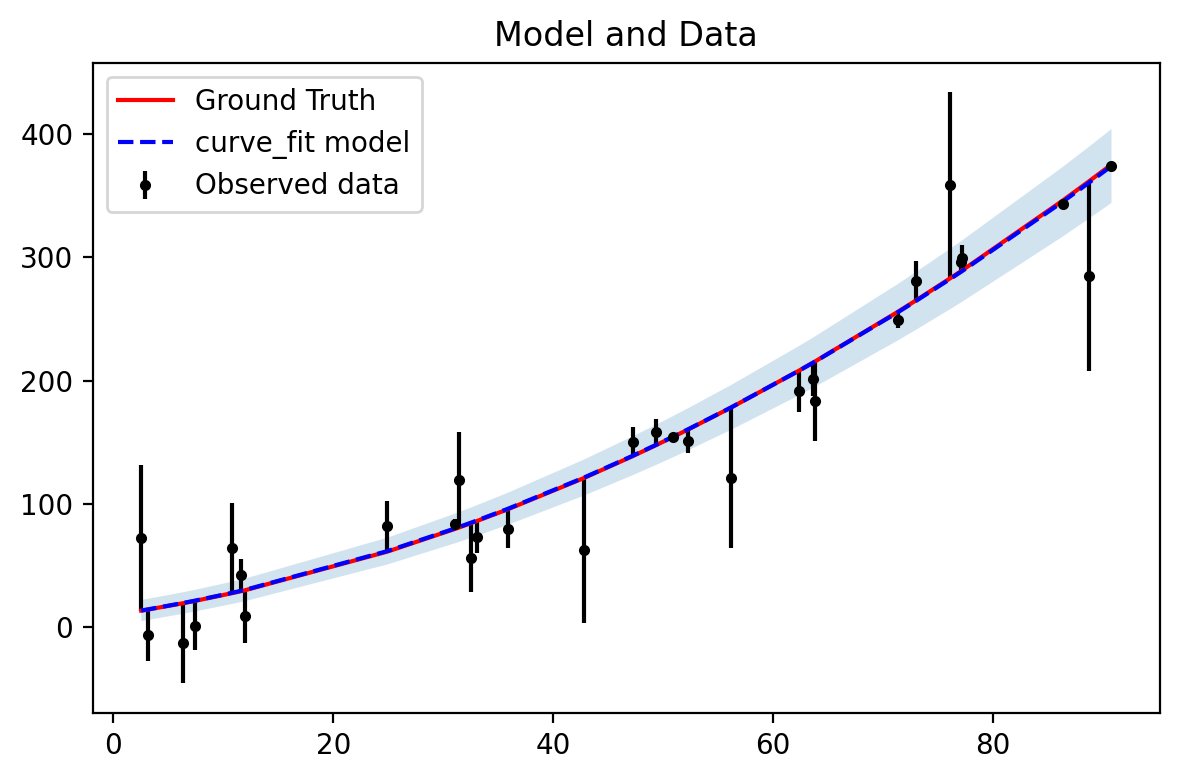

In [10]:
# we calculate the best estimate
predictions_errors_1 = forward_model(x,*params)

# FIGURE
plt.figure(dpi=200)

plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")

# plotting the model
plt.plot(x,un.nominal_values(predictions_errors_1),"b--",label="curve_fit model")

# plotting its error bars
plt.fill_between(x, un.nominal_values(predictions_errors_1) - un.std_devs(predictions_errors_1),
                 un.nominal_values(predictions_errors_1) + un.std_devs(predictions_errors_1), alpha=0.2, zorder=-1)

plt.title("Model and Data")
plt.legend(loc="best")

plt.tight_layout()


# Correlated parameters/variables...

Now parameters are nearly ALWAYS correlated with each others... For instance, if we print pcov...

In [11]:
print(pcov)

[[ 7.31978146e+01 -2.25901226e+00  1.60963168e-02]
 [-2.25901226e+00  7.00068371e-02 -5.01719683e-04]
 [ 1.60963168e-02 -5.01719683e-04  3.62893483e-06]]


There is some correlation between the different variables...

To take this into account, we can use a modification of the variance formula. For simplicity, we can write the formula for two model variables $m_i$ and $m_j$, but we can expand it easily. So we have

$ \sigma_y = \sqrt((\frac{\delta f}{\delta m_i})^2\sigma_{m_i}^2 
                   + (\frac{\delta f}{\delta m_j})^2\sigma_{m_j}^2
                   + 2\sigma^2_{m_im_j}\frac{\delta f}{\delta m_i}\frac{\delta f}{\delta m_j})$   eq. 2
                   
Fortunately, *uncertainties* allows to deal with this... because it can get extremely complex for real-world models.

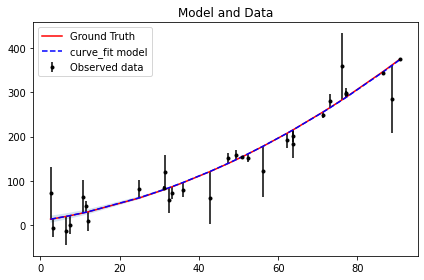

In [12]:
# after reading the docs, we see that we can create a 
# new params array with taking into account the covariance, and use if for error propagation.
params_2 = uncertainties.correlated_values(popt, pcov)

# we calculate the best estimate
predictions_errors_2 = forward_model(x,*params_2)

# FIGURE
plt.figure()

plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")

# plotting the model
plt.plot(x,un.nominal_values(predictions_errors_2),"b--",label="curve_fit model")

# plotting its error bars
plt.fill_between(x, un.nominal_values(predictions_errors_2) - un.std_devs(predictions_errors_2),
                 un.nominal_values(predictions_errors_2) + un.std_devs(predictions_errors_2), alpha=0.2, zorder=-1)

plt.title("Model and Data")
plt.legend(loc="best")

plt.tight_layout()


We see that the error bars even become non apparent when taking into account covariance!

Always be careful with this !